# Spray Glider - Automated Spatial Scales Analysis  

**Purpose**: Code for computing the mean autocorrelation function for scalar fields from spray glider transects.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Supress decrepation warnings

In [2]:
import warnings

# Suppress specific category of warnings (e.g., deprecation warnings)
warnings.filterwarnings("ignore")


Import python libraries


In [3]:
#--- Build-in Python Functions ---# 
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime
import sys
import os
from geopy.distance import geodesic
from scipy import stats

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
import cartopy_figs as cart
from autocorr import compute_decor_scale, compute_glider_autocorr, compute_glider_autocorr_interp
from spectra import spectra_autocov

Set data analysis parameters

In [4]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, doxy, chla, density   
option_depth_average = 0      # Specifies if the variable will be depth averaged or not
option_interp        = 1      # Specifies whether the transect will be interpolated or bin averaged onto a regular grid. If 0, data is bin averaged. If 1, data is interpolated.  

# Set time and space parameters
years_d      =  ['2020','2021','2022','2023']  #['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']   # Specifies the year(s) to analyze
depth_lim    = 10                            # Specifies the bottom depth limit of the depth integration or the single depth for the data record. IMPORTANT: Make sure the single depth is an integer range from 10 to 500 meters in steps of 10 meters
L = 2.5 if option_interp == 0 else 1.5       # Spcifies the spatial interval for bin averaging 
on_lim       = -1000                         # Specifies the depth limit for the onshelf region 
off_lim      = -3150                         # Specifies the depth limit for the offshelf region 
trans_lim    = [on_lim + 100, off_lim - 300] # Specifies the depth limit for the transition region 
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function   

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

# Set plotting parameters 
fontsize = 14

Load spray glider and intermediate data products (**NOTE**:  The intermediate data have the same profile coordinate as the spray glider data and have the same mask as the longitude and latitude from the spray glider data)

In [5]:
#--- Spray Glider Data ---# 
filename_sg = PATH + "/data/spray_gliders/CUGN_line_80.nc"
nc = Dataset(filename_sg, 'r')

# Extract data variables
profile = nc.variables['profile'][:]
depth   = nc.variables['depth'][:]

lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

temperature = nc.variables['temperature'][:]
salinity = nc.variables['salinity'][:]
doxy = nc.variables['doxy'][:]
chla = nc.variables['chlorophyll_a'][:]

#--- Intermediate Data ---# 
filename_int = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data.nc"
nc = Dataset(filename_int, 'r')

# Extract data variables
dist           = nc.variables['DIST'][:]
Time           = nc.variables['TIME'][:]
water_depth    = nc.variables['WATER_DEPTH'][:]

sigma0         = nc.variables['SIG'][:]
SA             = nc.variables['ASal'][:]
CT             = nc.variables['CTemp'][:]

# Set the data to preform the scale analysis on
if option_var == 'temp':
    data = temperature
elif option_var == 'sal':
    data = salinity
elif option_var == 'doxy':
    data = doxy
elif option_var == 'chla':
    data = chla
elif option_var == 'density':
    data = sigma0

Now grab data from multiple years

In [6]:
# Grab data from a given depth or depth average
if option_depth_average == 0:
    data_dp = data[depth == depth_lim,:].T.squeeze()
else: 
    data_dp = np.ma.mean(data[(depth >= depth[0]) & (depth <= depth_lim),:].T,axis=1)

# Grab indices of masked elements 
time_mask = np.array(np.where(time.mask))   
lon_mask  = np.array(np.where(lon.mask))
lat_mask  = np.array(np.where(lat.mask))

# Check if the masked elements in time, lon, and lat 
if (time_mask == lon_mask).all() and (time_mask == lat_mask).all() and (lon_mask == lat_mask).all():

    # Combine masks from time and temperature 
    data_mask = np.logical_or(data_dp.mask,time.mask)

    # Mask temperature, time, lon, and lat on the new mask 
    data_m = np.ma.masked_where(data_mask,data_dp)
    time_m = np.ma.masked_where(data_mask,time)
    lon_m  = np.ma.masked_where(data_mask,lon)
    lat_m  = np.ma.masked_where(data_mask,lat)
    dist_m = np.ma.masked_where(data_mask,dist)
    water_depth_m = np.ma.masked_where(data_mask,water_depth)

    # Removed Masked values 
    data_m_cn = data_m.compressed()
    time_m_cn = time_m.compressed()
    lon_m_cn  = lon_m.compressed()
    lat_m_cn  = lat_m.compressed()
    dist_m_cn   = dist_m.compressed()
    water_depth_m_cn = water_depth_m.compressed()

    # Grab the years from the cleaned time array 
    years  = np.array([y.year for y in time_m_cn])

    # Initialize year array 
    data_t = []
    time_t = []
    lon_t = []
    lat_t = []
    dist_t = []
    water_depth_t = []

    # Loop through years 
    for iyear in range(0,len(years_d)):

        # Find indices for ith year
        year_idx = years == int(years_d[iyear]) 

        # Obtain time steps from ith year
        data_t.extend(data_m_cn[year_idx])
        time_t.extend(time_m_cn[year_idx])
        lon_t.extend(lon_m_cn[year_idx])
        lat_t.extend(lat_m_cn[year_idx])
        dist_t.extend(dist_m_cn[year_idx])
        water_depth_t.extend(water_depth_m_cn[year_idx])

# Convert variables to numpy arrays 
data_t        = np.ma.array(data_t)
time_t        = np.ma.array(time_t)
lon_t         = np.ma.array(lon_t)
lat_t         = np.ma.array(lat_t)
dist_t        = np.ma.array(dist_t)
water_depth_t = np.ma.array(water_depth_t)

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_t])

Plot the hovmoller diagram

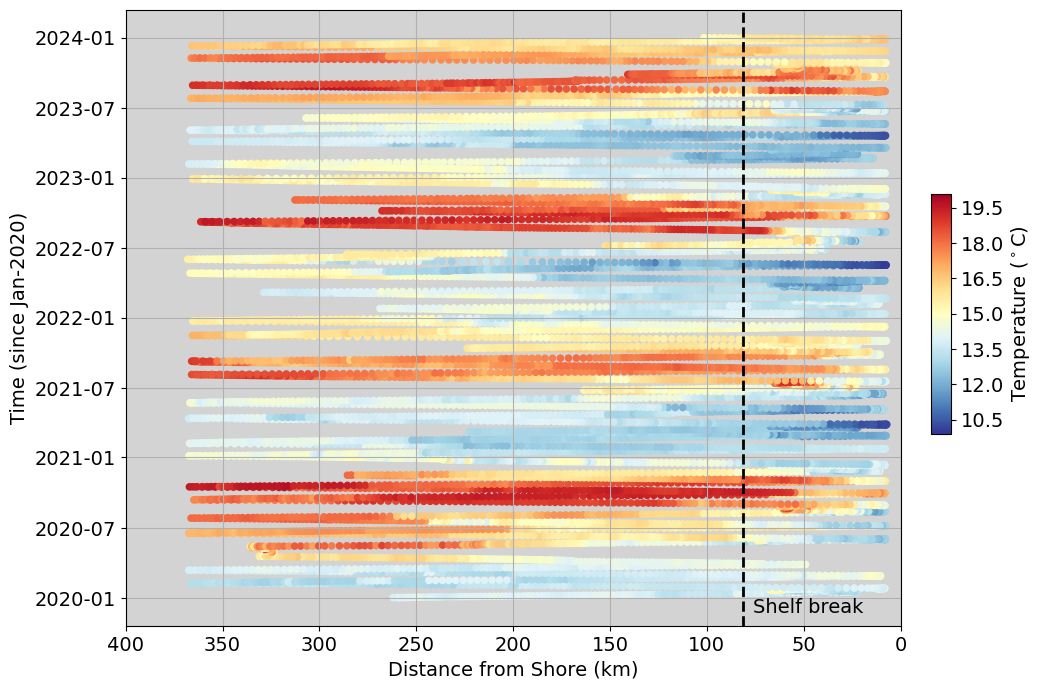

In [7]:
# Compute the distance to the shelf break from the shore (with Point Conception as the reference point) 
point_pc = (34.4488552,-120.457673)
point_sb = (34.23,-121.3)
distance_sb = geodesic(point_sb, point_pc).kilometers

# Specify colormap 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    cbar_label = r'Temperature ($^\circ$C)'
elif option_var == 'sal':
    cmap = 'BrBG_r'
    cbar_label = r'Salinity (psu)'
elif option_var == 'doxy':
    cmap = 'PRGn'
    cbar_label = r'Dissolved Oxygen (kg$^{-1}$)'
elif option_var == 'chla':
    cmap = 'PRGn'
    cbar_label = r'$\log_{10}$[Chlorophyll-a (mg m$^{-3}$)]'
elif option_var == 'density': 
    cmap = 'Spectral_r'
    cbar_label = r'$\sigma_0$ (kg m$^{-3}$)'

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time color coded by temperature
if option_var == 'chla':
    sc = axes.scatter(dist_t,time_dt,c=np.log10(data_t),cmap=cmap,s=20,marker='o')
else: 
    sc = axes.scatter(dist_t,time_dt,c=data_t,cmap=cmap,s=20,marker='o')

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='k', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='k', fontsize=fontsize, ha='left',va='top',rotation=0)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Create colormbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    sc,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=cbar_label,
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set Colorbar limits 
#sc.set_clim(200, 300)

# Set the background color of the axes
axes.set_facecolor('lightgray')

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_' + option_var + '_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_lim_' + str(depth_lim), bbox_inches = 'tight', dpi=300)

Spilt up the legs of the glider trajectory 

In [8]:
# Compute a moving mean filter (to smooth small fluctuations in the trajectory especially during turns)
window_size = 20 
dist_sm = np.convolve(dist_t, np.ones(window_size)/window_size, mode='same')

# Compute the distance between consecutive points traversed relative to shore (positive = moving off-shore, negative = moving on-shore) 
# and use prepend to ensure dist_diff is the same length as dist_t and dist_sm (first element is the difference between dist_sm[0] and dist_sm[0]) = 0
# which essentially means the glider starts from a stationary point)
dist_diff = np.diff(dist_sm, prepend = dist_sm[0]) 

# Determine direction by creating an array where points satisfying the off-shore condition are labeled as 1 and false elements are labeled as -1 
# (offshore = 1, onshore = -1)
direction = np.where(dist_diff > 0, 1, -1)

#--- Identify transition points ---#

# Get indicies where the direction changes 
transitions = np.where(np.diff(direction) != 0)[0] + 1  

# Initialize an array of segment labels (will later be assigned values based on offshore/onshore transitions)
segments = np.zeros_like(dist_sm, dtype=int) 

# Initialize segment label loop variable 
segment_id = 0

# Loop through segment identified by transition 
for i in range(len(transitions) - 1):

    # Assign segment labels 
    segments[transitions[i]:transitions[i + 1]] = segment_id

    # Increment segment label 
    segment_id += 1

#--- Remove short segments ---# 

# Count occurrences of each segment
segment_lengths = np.bincount(segments) 

# Set threshold for segment length (80 = only long transects, 50 = long and short transects)
min_segment_size = 93

# Identify valid transects labels 
valid_segments = np.where(segment_lengths >= min_segment_size)[0]

# Apply mask to remove short segments
mask = np.isin(segments, valid_segments)

#--- Remove Turning Periods after Segmentation ---#

# Compute speed using the raw distance (absolute change over time)
dx = np.abs(np.diff(dist_t, prepend=dist_t[0])) * 1000   # Units: meters
dt = np.diff(time_dt, prepend=time_dt[0]).astype('timedelta64[s]').astype(float)  # Units: seconds 
speed = (dx / dt)  # Units: m/s

# Define a threshold for slow movement (adjust as needed)
speed_threshold = 0.15

# Mask out points where speed is too low (turning points)
valid_speed_mask = speed > speed_threshold

# Define a minimum distance from shore threshold (adjust as needed)
min_distance_threshold = 10 

# Mask out points where distance from shore is too small
valid_distance_mask = dist_t >= min_distance_threshold

# Apply this mask **after segmentation** to remove turns while keeping valid transects
final_mask = mask & valid_speed_mask & valid_distance_mask  # Ensure both masks are applied correctly

#--- Filter out short segments ---# 
time_seg = time_dt[final_mask]
dist_seg = dist_t[final_mask]
data_seg = data_t[final_mask]
water_depth_seg = water_depth_t[final_mask]
segment_labels = segments[final_mask]
direction_seg = direction[final_mask]

Plot segmentation results

In [9]:
# Check if we want to plot  
if option_plot == 1:

    # Create figure 
    fig = plt.figure(figsize=(12, 6))

    # Plot the full glider trajectory 
    plt.plot(time_dt,dist_t,'k-')
    #plt.plot(time_dt,dist_sm,'k.:')

    # Obtain unique segments 
    unique_segments = np.unique(segment_labels)

    # Loop through segments 
    for seg in unique_segments:

        # Find indices of the ith segment
        seg_mask = segment_labels == seg

        # Set the color and label of the line based on the direction 
        color = "blue" if direction[final_mask][seg_mask][0] == 1 else "red"
        label = "Moving Offshore" if direction[final_mask][seg_mask][0] == 1 else "Moving Onshore"

        # Plot glider trajectory 
        plt.plot(time_seg[seg_mask], dist_seg[seg_mask], color=color, label=label, linewidth=3)

    # Get all legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Set figure attributes 
    plt.xlabel("Time")
    plt.ylabel("Distance from Shore (km)")
    #plt.xlim(time_dt[int(np.round(len(time_dt)*0.9))],time_dt[int(np.round(len(time_dt)*1))])
    #plt.ylim(0,30)
    plt.title("Spray Glider Offshore & Onshore Segments: " + str(len(unique_segments)) + ' segments')
    plt.legend(handles[:2], labels[:2], loc="upper right")
    plt.grid()
    plt.show()

    # Save figure 
    fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/onshore_offshore_segments_'  + years_d[0] + '_to_' + years_d[-1], bbox_inches = 'tight', dpi=300)

Compute off-shore and on-shore autocorrelation functions for each transect

Transect number: 1
Transect number: 2
Transect number: 3
Transect number: 4
Transect number: 5
Ran into error, skipping transect!
Transect number: 6
Ran into error, skipping transect!
Transect number: 7
Ran into error, skipping transect!
Transect number: 8
Transect number: 9
Transect number: 10
Transect number: 11
Transect number: 12
Transect number: 13
Transect number: 14
Transect number: 15
Transect number: 16
Transect number: 17
Transect number: 18
Transect number: 19
Transect number: 20
Transect number: 21
Transect number: 22
Transect number: 23
Transect number: 24
Ran into error, skipping transect!
Transect number: 25
Transect number: 26
Transect number: 27
Transect number: 28
Transect number: 29
Transect number: 30
Transect number: 31
Transect number: 32
Transect number: 33
Transect number: 34
Transect number: 35
Transect number: 36
Transect number: 37
Transect number: 38
Transect number: 39
Transect number: 40
Transect number: 41
Transect number: 42
Ran into error, skipping tran

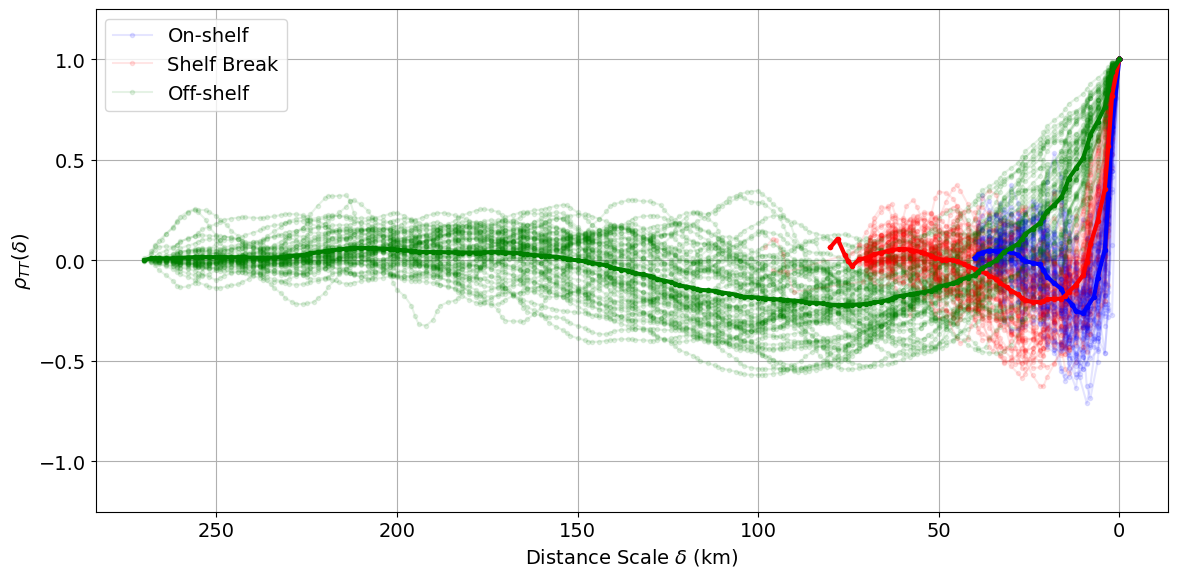

In [10]:
# Initialize counters
cn    = 0  # Counter for number of analyzable transects 
N     = 0  # Counter for total number of transects segmented
skips = 0  # Counter for number of transects skipped 

# Obtain unique segments 
unique_segments = np.unique(segment_labels)

# Initialize arrays  
L_on             = []
L_trans          = []
L_off            = []
meanTime           = []
autocorr_on        = []
autocorr_trans     = []
autocorr_off       = []
autocorr_on_n       = []
autocorr_trans_n   = []
autocorr_off_n     = []
autocov_on         = []
autocov_trans      = []
autocov_off        = []
autocov_full       = []
delta_on           = []
delta_trans        = []
delta_off          = []
delta_full         = []
delta_on_n         = []
delta_trans_n      = []
delta_off_n        = []

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
elif option_var == 'doxy':
    ylabel = r'$\rho_{OO} (\delta)$'
elif option_var == 'chla':
    ylabel = r'$\rho_{CC} (\delta)$'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'
dirTransect = PATH + '/figs/spray_glider/scale_analysis/transect_' + option_var + '_depth_lim_' + str(depth_lim) + '_' + estimator

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure 
fig = plt.figure(figsize=(12, 6))

# Loop through segments 
for seg in unique_segments:

    # Increment and print Transect Number 
    N += 1 
    print('Transect number: ' + str(N))
    
    # Find indices of the ith segment
    seg_mask = segment_labels == seg

    # Obtain data for the ith segement 
    itime = time_seg[seg_mask]
    idist = dist_seg[seg_mask]
    idata = data_seg[seg_mask]
    iwater_depth = water_depth_seg[seg_mask]
    idirection = direction_seg[seg_mask]

    # Try statement to handle exceptions so that errors can be passed without crashing the program
    try: 

        # Check if that transect extends from the on region shore to off shore
        if (np.ma.max(water_depth_seg) >= on_lim + 400) & (np.ma.min(water_depth_seg) <= off_lim - 400):

            # Set the direction (Moving Onshore = -1, Moving Offshore = 1)
            idir = stats.mode(idirection, keepdims=True).mode[0]

            # Convert to timestamps (numerical values in seconds)
            timestamps = np.array([dt.timestamp() for dt in itime])

            # Compute mean timestamp for segment and convert to datetime
            mean_timestamp = np.mean(timestamps)
            mean_datetime  = datetime.fromtimestamp(mean_timestamp)

            # Set path for saving figures
            dirOut = dirTransect + '_time_' + str(mean_datetime.year) + str(mean_datetime.month) + str(mean_datetime.day) + '_' + str(mean_datetime.hour)

            # Compute autocorrelation functions for each transect
            if option_interp == 1: 
                (
                    iautocorr_on, iautocorr_trans, iautocorr_off,              # Autocorrelation function normalized by zeroth lag 
                    iautocorr_on_n, iautocorr_trans_n, iautocorr_off_n,        # Autocorrelation function normalized by first lag 
                    iautocov_on, iautocov_trans, iautocov_off, iautocov_full,  # Autocovariance functon (for computing the spectrum)
                    iL_on, iL_trans, iL_off,                                   # Decorrelation scales (computed from the first lag normalization)
                    idist_on, idist_trans, idist_off, idist_full,              # Distance from shore for each region 
                    idist_scale_on_n, idist_scale_trans_n, idist_scale_off_n,  # Distance scale for each region 
                ) = compute_glider_autocorr_interp(
                    idist, idata, iwater_depth, L, 
                    on_lim, off_lim, trans_lim, idir, estimator, 
                    option_plot, dirOut
                )
            else: 
                (
                    iautocorr_on, iautocorr_trans, iautocorr_off,              # Autocorrelation function normalized by zeroth lag 
                    iautocorr_on_n, iautocorr_trans_n, iautocorr_off_n,        # Autocorrelation function normalized by first lag 
                    iautocov_on, iautocov_trans, iautocov_off, iautocov_full,  # Autocovariance functon (for computing the spectrum)
                    iL_on, iL_trans, iL_off,                                   # Decorrelation scales (computed from the first lag normalization)
                    idist_on, idist_trans, idist_off, idist_full,              # Distance from shore for each region 
                    idist_scale_on_n, idist_scale_trans_n, idist_scale_off_n,  # Distance scale for each region 
                ) = compute_glider_autocorr(
                    idist, idata, iwater_depth, L, 
                    on_lim, off_lim, trans_lim, idir, estimator, 
                    option_plot, dirOut
                )

            # Compute the distance scale for each region  
            dist_scale_on    = np.round(idist_on-idist_on[0],0)
            dist_scale_trans = np.round(idist_trans-idist_trans[0],0)
            dist_scale_off   = np.round(idist_off-idist_off[0],0)
            dist_scale_full  = np.round(idist_full-idist_full[0],0)

            # Round the distance scale for the first lag normalized autocorrelation function 
            dist_scale_on_n    = np.round(dist_scale_on,0)
            dist_scale_trans_n = np.round(dist_scale_trans,0)
            dist_scale_off_n   = np.round(dist_scale_off,0)

            # Append the autocorrelation function and distance scale to list 
            L_on.append(iL_on)
            L_trans.append(iL_trans)
            L_off.append(iL_off)
            autocorr_on.append(iautocorr_on)
            autocorr_trans.append(iautocorr_trans)
            autocorr_off.append(iautocorr_off)
            autocorr_on_n.append(iautocorr_on_n)
            autocorr_trans_n.append(iautocorr_trans_n)
            autocorr_off_n.append(iautocorr_off_n)
            autocov_on.append(iautocov_on)
            autocov_trans.append(iautocov_trans)
            autocov_off.append(iautocov_off)
            autocov_full.append(iautocov_full)
            delta_on.append(dist_scale_on)
            delta_trans.append(dist_scale_trans)
            delta_off.append(dist_scale_off)
            delta_full.append(dist_scale_full)
            delta_on_n.append(dist_scale_on_n)
            delta_trans_n.append(dist_scale_trans_n)
            delta_off_n.append(dist_scale_off_n)

            # Convert back to datetime
            meanTime.append(datetime.fromtimestamp(mean_timestamp)) 

            # Reinitialize counter
            cn += 1

            # Plot autocorrelation function 
            plt.plot(dist_scale_on,iautocorr_on,'b.-',alpha=0.1)
            plt.plot(dist_scale_trans,iautocorr_trans,'r.-',alpha=0.1)
            plt.plot(dist_scale_off,iautocorr_off,'g.-',alpha=0.1)

    except Exception: 

        # Print warining message 
        print('Ran into error, skipping transect!')

        # Count the number of transect skips 
        skips += 1

# Print the number of skips 
print('Number of skipped transects: ' + str(skips) + ' of ' + str(N))

# Determine the maximum length of the autocorrelation function
max_length_on    = max([len(a) for a in autocorr_on])
max_length_trans = max([len(a) for a in autocorr_trans])
max_length_off   = max([len(a) for a in autocorr_off])

# Initailize array 
autocorr_on_array    = np.full((len(autocorr_on),max_length_on), np.nan)
autocorr_trans_array = np.full((len(autocorr_trans),max_length_trans), np.nan)
autocorr_off_array   = np.full((len(autocorr_off),max_length_off), np.nan)

#--- On-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocorr_on)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocorr_on_array[i,:] = np.pad(autocorr_on[i], (0, max_length_on - len(autocorr_on[i])), constant_values=np.nan)

#--- Shelf Break ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocorr_trans)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocorr_trans_array[i,:] = np.pad(autocorr_trans[i], (0, max_length_trans - len(autocorr_trans[i])), constant_values=np.nan)

#--- Off-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocorr_off)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocorr_off_array[i,:] = np.pad(autocorr_off[i], (0, max_length_off - len(autocorr_off[i])), constant_values=np.nan)

# Compute the mean autocorrelation function 
meanAutoCorr_on    = np.nanmean(autocorr_on_array, axis=0) 
meanAutoCorr_trans = np.nanmean(autocorr_trans_array, axis=0)
meanAutoCorr_off   = np.nanmean(autocorr_off_array, axis=0) 

# Compute the standard deviation and the number of samples 
stdAutoCorr_on    = np.nanstd(autocorr_on_array, axis=0, ddof=1)
stdAutoCorr_trans = np.nanstd(autocorr_trans_array, axis=0, ddof=1)
stdAutoCorr_off   = np.nanstd(autocorr_off_array, axis=0, ddof=1)
nAutoCorr_on    = np.count_nonzero(~np.isnan(autocorr_on_array), axis=0)
nAutoCorr_trans = np.count_nonzero(~np.isnan(autocorr_trans_array), axis=0)
nAutoCorr_off   = np.count_nonzero(~np.isnan(autocorr_off_array), axis=0)

# Compute the standard error of the mean (assuming that each data point is an independent observations)
stdmAutoCorr_on    = stdAutoCorr_on/np.sqrt(nAutoCorr_on)
stdmAutoCorr_trans = stdAutoCorr_trans/np.sqrt(nAutoCorr_trans)
stdmAutoCorr_off   = stdAutoCorr_off/np.sqrt(nAutoCorr_off)

# Set the distance scale of the mean autocorrelation functions
longest_index = np.argmax([len(a) for a in delta_on])
D_on          = delta_on[longest_index]
longest_index = np.argmax([len(a) for a in delta_trans])
D_trans       = delta_trans[longest_index]
longest_index = np.argmax([len(a) for a in delta_off])
D_off         = delta_off[longest_index]

# Plot the mean autocorrelation functions 
plt.plot(D_on,meanAutoCorr_on, 'b.-', linewidth=3)
plt.plot(D_trans,meanAutoCorr_trans, 'r.-', linewidth=3)
plt.plot(D_off,meanAutoCorr_off, 'g.-', linewidth=3)

# Set axis attributes
plt.xlabel(r"Distance Scale $\delta$ (km)")
plt.ylabel(ylabel)
plt.ylim(-1.25,1.25)
plt.grid()
plt.legend(["On-shelf", "Shelf Break", "Off-shelf"], loc="upper left")

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis() 

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/autocorr_' + option_var + '_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_' + estimator + '_ALL', bbox_inches = 'tight', dpi=300)

# Convert meanTime and decorrelation scales into numpy arrays
L_on_a     = np.array(L_on)
L_trans_a  = np.array(L_trans)
L_off_a    = np.array(L_off)
meanTime = np.array(meanTime)

# Compute the mean decorrelation spatial scale 
L_on_m = np.mean(L_on_a)
L_trans_m = np.mean(L_trans_a)
L_off_m = np.mean(L_off_a)

Compute the mean autocorrelation function for the first lag normalization 

In [11]:
# Determine the maximum length of the autocorrelation function
max_length_on    = max([len(a) for a in autocorr_on_n])
max_length_trans = max([len(a) for a in autocorr_trans_n])
max_length_off   = max([len(a) for a in autocorr_off_n])

# Initailize array 
autocorr_on_n_array    = np.full((len(autocorr_on_n),max_length_on), np.nan)
autocorr_trans_n_array = np.full((len(autocorr_trans_n),max_length_trans), np.nan)
autocorr_off_n_array   = np.full((len(autocorr_off_n),max_length_off), np.nan)

#--- On-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocorr_on)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocorr_on_n_array[i,:] = np.pad(autocorr_on_n[i], (0, max_length_on - len(autocorr_on_n[i])), constant_values=np.nan)

#--- Shelf Break ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocorr_trans)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocorr_trans_n_array[i,:] = np.pad(autocorr_trans_n[i], (0, max_length_trans - len(autocorr_trans_n[i])), constant_values=np.nan)

#--- Off-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocorr_off)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocorr_off_n_array[i,:] = np.pad(autocorr_off_n[i], (0, max_length_off - len(autocorr_off_n[i])), constant_values=np.nan)

# Compute the mean autocorrelation function 
meanAutoCorr_on_n    = np.nanmean(autocorr_on_n_array, axis=0) 
meanAutoCorr_trans_n = np.nanmean(autocorr_trans_n_array, axis=0)
meanAutoCorr_off_n   = np.nanmean(autocorr_off_n_array, axis=0) 

# Compute the standard deviation and the number of samples 
stdAutoCorr_on_n    = np.nanstd(autocorr_on_n_array, axis=0, ddof=1)
stdAutoCorr_trans_n = np.nanstd(autocorr_trans_n_array, axis=0, ddof=1)
stdAutoCorr_off_n   = np.nanstd(autocorr_off_n_array, axis=0, ddof=1)
nAutoCorr_on_n    = np.count_nonzero(~np.isnan(autocorr_on_n_array), axis=0)
nAutoCorr_trans_n = np.count_nonzero(~np.isnan(autocorr_trans_n_array), axis=0)
nAutoCorr_off_n   = np.count_nonzero(~np.isnan(autocorr_off_n_array), axis=0)

# Compute the standard error of the mean (assuming that each data point is an independent observations)
stdmAutoCorr_on_n   = stdAutoCorr_on_n/np.sqrt(nAutoCorr_on_n)
stdmAutoCorr_trans_n = stdAutoCorr_trans_n/np.sqrt(nAutoCorr_trans_n)
stdmAutoCorr_off_n   = stdAutoCorr_off_n/np.sqrt(nAutoCorr_off_n)

# Set the distance scale of the mean autocorrelation functions
longest_index = np.argmax([len(a) for a in delta_on_n])
D_on_n          = delta_on_n[longest_index]
longest_index = np.argmax([len(a) for a in delta_trans_n])
D_trans_n      = delta_trans_n[longest_index]
longest_index = np.argmax([len(a) for a in delta_off_n])
D_off_n         = delta_off_n[longest_index]


Compute the mean autocovariance function

In [12]:
# Determine the maximum length of the autocorrelation function
max_length_on    = max([len(a) for a in autocov_on])
max_length_trans = max([len(a) for a in autocov_trans])
max_length_off   = max([len(a) for a in autocov_off])
max_length_full   = max([len(a) for a in autocov_full])

# Initailize array 
autocov_on_array    = np.full((len(autocov_on),max_length_on), np.nan)
autocov_trans_array = np.full((len(autocov_trans),max_length_trans), np.nan)
autocov_off_array   = np.full((len(autocov_off),max_length_off), np.nan)
autocov_full_array   = np.full((len(autocov_full),max_length_full), np.nan)

#--- On-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocov_on)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocov_on_array[i,:] = np.pad(autocov_on[i], (0, max_length_on - len(autocov_on[i])), constant_values=np.nan)

#--- Shelf Break ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocov_trans)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocov_trans_array[i,:] = np.pad(autocov_trans[i], (0, max_length_trans - len(autocov_trans[i])), constant_values=np.nan)

#--- Off-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocov_off)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocov_off_array[i,:] = np.pad(autocov_off[i], (0, max_length_off - len(autocov_off[i])), constant_values=np.nan)

#--- Full record ---# 
# Loop through autocorrelation functions
for i in range(0,len(autocov_full)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    autocov_full_array[i,:] = np.pad(autocov_full[i], (0, max_length_full - len(autocov_full[i])), constant_values=np.nan)


# Compute the mean autocorrelation function 
meanAutoCov_on    = np.nanmean(autocov_on_array, axis=0) 
meanAutoCov_trans = np.nanmean(autocov_trans_array, axis=0)
meanAutoCov_off   = np.nanmean(autocov_off_array, axis=0) 
meanAutoCov_full   = np.nanmean(autocov_full_array, axis=0) 

# Compute the standard deviation and the number of samples 
stdAutoCov_on    = np.nanstd(autocov_on_array, axis=0, ddof=1)
stdAutoCov_trans = np.nanstd(autocov_trans_array, axis=0, ddof=1)
stdAutoCov_off   = np.nanstd(autocov_off_array, axis=0, ddof=1)
stdAutoCov_full   = np.nanstd(autocov_full_array, axis=0, ddof=1)
nAutoCov_on      = np.count_nonzero(~np.isnan(autocov_on_array), axis=0)
nAutoCov_trans = np.count_nonzero(~np.isnan(autocov_trans_array), axis=0)
nAutoCov_off   = np.count_nonzero(~np.isnan(autocov_off_array), axis=0)
nAutoCov_full   = np.count_nonzero(~np.isnan(autocov_full_array), axis=0)

# Compute the standard error of the mean (assuming that each data point is an independent observations)
stdmAutoCov_on   = stdAutoCov_on/np.sqrt(nAutoCov_on)
stdmAutoCov_trans = stdAutoCov_trans/np.sqrt(nAutoCov_trans)
stdmAutoCov_off   = stdAutoCov_off/np.sqrt(nAutoCov_off)
stdmAutoCov_full   = stdAutoCov_full/np.sqrt(nAutoCov_full)

# Set the distance scale of the mean autocorrelation functions
longest_index = np.argmax([len(a) for a in delta_on])
D_on_cov          = delta_on[longest_index]
longest_index = np.argmax([len(a) for a in delta_trans])
D_trans_cov      = delta_trans[longest_index]
longest_index = np.argmax([len(a) for a in delta_off])
D_off_cov         = delta_off[longest_index]
longest_index = np.argmax([len(a) for a in delta_full])
D_full_cov         = delta_full[longest_index]

Compute the mean autocorrelation normalized by the first lag from the autocovariance (!!!! I need to compute the biased estimate for this to work !!!!)

In [13]:
# Compute mean autocorrelation function 
meanAutoCorr_on_cov    = np.insert(meanAutoCov_on[1:]/meanAutoCov_on[1], 0, 1)
meanAutoCorr_trans_cov = np.insert(meanAutoCov_trans[1:]/meanAutoCov_trans[1], 0, 1)
meanAutoCorr_off_cov   = np.insert(meanAutoCov_off[1:]/meanAutoCov_off[1], 0, 1)
meanAutoCorr_full_cov   = np.insert(meanAutoCov_full[1:]/meanAutoCov_full[1], 0, 1)

# Propagate error
stdmAutoCorr_on_cov    = stdmAutoCov_on/meanAutoCov_on[1]
stdmAutoCorr_trans_cov  = stdmAutoCov_trans/meanAutoCov_trans[1]
stdmAutoCorr_off_cov    = stdmAutoCov_off/meanAutoCov_off[1]
stdmAutoCorr_full_cov    = stdmAutoCov_full/meanAutoCov_full[1]

Compute the decorrelation scale from the autocorrelation computed from the mean autocovariance 

In [14]:
# Set the estimator because the autocovariance function is computed with the unbiased estimator for the spectral estimate
estimator = 'unbiased' 

#--- Off-shelf ---# 

# Compute the decorrelation scale 
L_on_cov  = compute_decor_scale(meanAutoCorr_on_cov[1:],D_on_cov[1:],L,estimator,1)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_on_ustd = compute_decor_scale(meanAutoCorr_on_cov[1:] + stdmAutoCorr_on_cov[1:] ,D_on_cov[1:] ,L,estimator,1)
L_on_lstd = compute_decor_scale(meanAutoCorr_on_cov[1:] - stdmAutoCorr_on_cov[1:] ,D_on_cov[1:] ,L,estimator,1)

# Compute the average standard error 
std_upper = L_on_ustd - L_on_cov
std_lower = abs(L_on_lstd - L_on_cov)
L_on_stdm_cov  = np.mean([std_upper, std_lower])

#--- Shelf-break ---#  

# Compute the decorrelation scale 
L_trans_cov  = compute_decor_scale(meanAutoCorr_trans_cov[1:] ,D_trans_cov[1:],L,estimator,1)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_trans_ustd = compute_decor_scale(meanAutoCorr_trans_cov[1:] + stdmAutoCorr_trans_cov[1:] ,D_trans_cov[1:] ,L,estimator,1)
L_trans_lstd = compute_decor_scale(meanAutoCorr_trans_cov[1:]  - stdmAutoCorr_trans_cov[1:] ,D_trans_cov[1:] ,L,estimator,1)

# Compute the average standard error 
std_upper = L_trans_ustd - L_trans_cov
std_lower = abs(L_trans_lstd - L_trans_cov)
L_trans_stdm_cov  = np.mean([std_upper, std_lower])

#--- Off-shelf ---# 

# Compute the decorrelation scale 
L_off_cov  = compute_decor_scale(meanAutoCorr_off_cov[1:] ,D_off_cov[1:] ,L,estimator,1)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_off_ustd = compute_decor_scale(meanAutoCorr_off_cov[1:]  + stdmAutoCorr_off_cov[1:] ,D_off_cov[1:] ,L,estimator,1)
L_off_lstd = compute_decor_scale(meanAutoCorr_off_cov[1:]  - stdmAutoCorr_off_cov[1:] ,D_off_cov[1:] ,L,estimator,1)

# Compute the average standard error 
std_upper = L_off_ustd - L_off_cov
std_lower = abs(L_off_lstd - L_off_cov)
L_off_stdm_cov  = np.mean([std_upper, std_lower])

#--- full record ---# 

# Compute the decorrelation scale 
L_full_cov  = compute_decor_scale(meanAutoCorr_full_cov[1:] ,D_full_cov[1:] ,L,estimator,1)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_full_ustd = compute_decor_scale(meanAutoCorr_full_cov[1:]  + stdmAutoCorr_full_cov[1:] ,D_full_cov[1:] ,L,estimator,1)
L_full_lstd = compute_decor_scale(meanAutoCorr_full_cov[1:]  - stdmAutoCorr_full_cov[1:] ,D_full_cov[1:] ,L,estimator,1)

# Compute the average standard error 
std_upper = L_full_ustd - L_full_cov
std_lower = abs(L_full_lstd - L_full_cov)
L_full_stdm_cov  = np.mean([std_upper, std_lower])

Compute the decorrelation scale from the mean autocorrelation function

In [15]:
# Set the estimator because the autocorrelation function is computed with the biased estimator 
estimator = 'biased' 

#--- Off-shelf ---# 

# Compute the decorrelation scale 
L_on = compute_decor_scale(meanAutoCorr_on[D_on <= 40],D_on[D_on <= 40],L,estimator,1)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_on_ustd = compute_decor_scale(meanAutoCorr_on[D_on <= 40] + stdmAutoCorr_on[D_on <= 40],D_on[D_on <= 40],L,estimator,1)
L_on_lstd = compute_decor_scale(meanAutoCorr_on[D_on <= 40] - stdmAutoCorr_on[D_on <= 40],D_on[D_on <= 40],L,estimator,1)

# Compute the average standard error 
std_upper = L_on_ustd - L_on
std_lower = abs(L_on_lstd - L_on)
L_on_stdm = np.mean([std_upper, std_lower])

#--- Shelf-break ---#  

# Compute the decorrelation scale 
L_trans = compute_decor_scale(meanAutoCorr_trans[D_trans <= 80],D_trans[D_trans <= 80],L,estimator,1)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_trans_ustd = compute_decor_scale(meanAutoCorr_trans[D_trans <= 80] + stdmAutoCorr_trans[D_trans <= 80],D_trans[D_trans <= 80],L,estimator,1)
L_trans_lstd = compute_decor_scale(meanAutoCorr_trans[D_trans <= 80] - stdmAutoCorr_trans[D_trans <= 80],D_trans[D_trans <= 80],L,estimator,1)

# Compute the average standard error 
std_upper = L_trans_ustd - L_trans
std_lower = abs(L_trans_lstd - L_trans)
L_trans_stdm = np.mean([std_upper, std_lower])

#--- Off-shelf ---# 

# Compute the decorrelation scale 
L_off = compute_decor_scale(meanAutoCorr_off,D_off,L,estimator,1)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_off_ustd = compute_decor_scale(meanAutoCorr_off + stdmAutoCorr_off,D_off,L,estimator,1)
L_off_lstd = compute_decor_scale(meanAutoCorr_off - stdmAutoCorr_off,D_off,L,estimator,1)

# Compute the average standard error 
std_upper = L_off_ustd - L_off
std_lower = abs(L_off_lstd - L_off)
L_off_stdm = np.mean([std_upper, std_lower])

Plot the average autocorrelation function with error bars

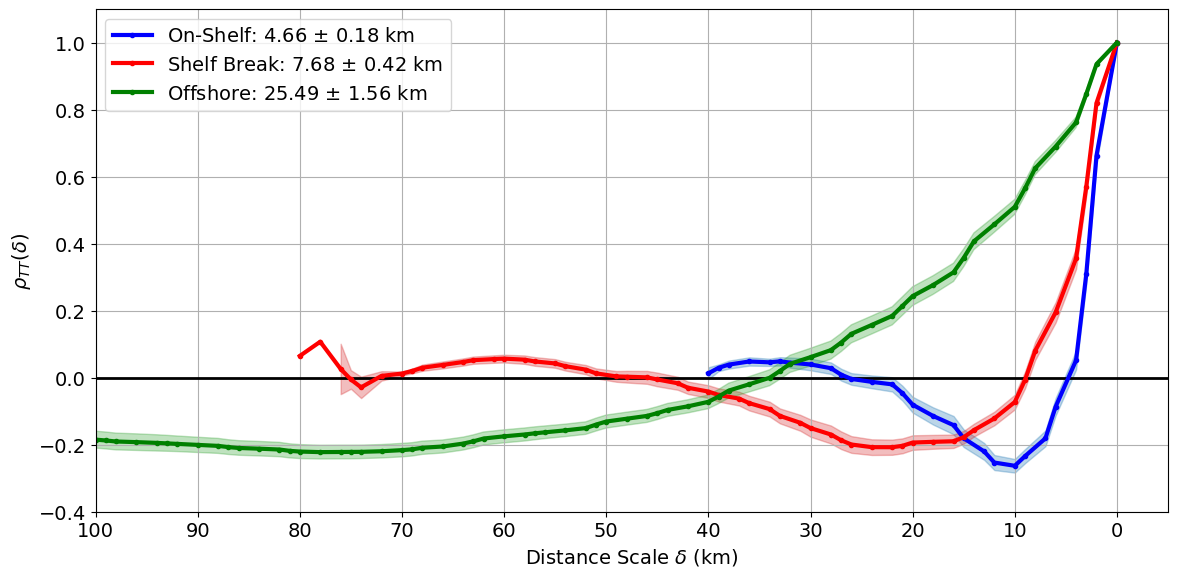

In [16]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure 
fig = plt.figure(figsize=(12, 6))

# Plot the zero crossing line
plt.axhline(0, color='k', linestyle='-', linewidth=2)

# Plot the mean autocorrelation functions 
plt.plot(D_on[D_on <= 40],meanAutoCorr_on[D_on <= 40], 'b.-', linewidth=3, label=r'On-Shelf: ' + str(np.round(L_on,2)) + r' $\pm$ ' + str(np.round(L_on_stdm,2)) + ' km')
plt.plot(D_trans[D_trans <= 80],meanAutoCorr_trans[D_trans <= 80], 'r.-', linewidth=3,label=r'Shelf Break: ' + str(np.round(L_trans,2)) + r' $\pm$ ' + str(np.round(L_trans_stdm,2)) + ' km' )
plt.plot(D_off,meanAutoCorr_off, 'g.-', linewidth=3,label=r'Offshore: ' + str(np.round(L_off,2)) + r' $\pm$ ' + str(np.round(L_off_stdm,2)) + ' km')

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(D_on[D_on <= 40],meanAutoCorr_on[D_on <= 40] - stdmAutoCorr_on[D_on <= 40],meanAutoCorr_on[D_on <= 40] + stdmAutoCorr_on[D_on <= 40],color="tab:blue",alpha=0.3)
plt.fill_between(D_trans[D_trans <= 80],meanAutoCorr_trans[D_trans <= 80] - stdmAutoCorr_trans[D_trans <= 80],meanAutoCorr_trans[D_trans <= 80] + stdmAutoCorr_trans[D_trans <= 80],color="tab:red",alpha=0.3)
plt.fill_between(D_off,meanAutoCorr_off - stdmAutoCorr_off,meanAutoCorr_off + stdmAutoCorr_off,color="tab:green",alpha=0.3)

# Set axis attributes
plt.xlabel(r"Distance Scale $\delta$ (km)")
plt.ylabel(ylabel)
plt.xlim(-5,100)
plt.ylim(-0.4,1.1)
plt.xticks(np.arange(0,100+10,10))
plt.grid()
plt.legend(loc="upper left")

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis() 

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
if option_interp == 0:
    fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/autocorr_' + option_var + '_errorbars_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_' + estimator + '_bin_averaged', bbox_inches = 'tight', dpi=300)
else: 
    fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/autocorr_' + option_var + '_errorbars_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_' + estimator + '_interpolated', bbox_inches = 'tight', dpi=300)

Plot the unbiased autocovariance function 

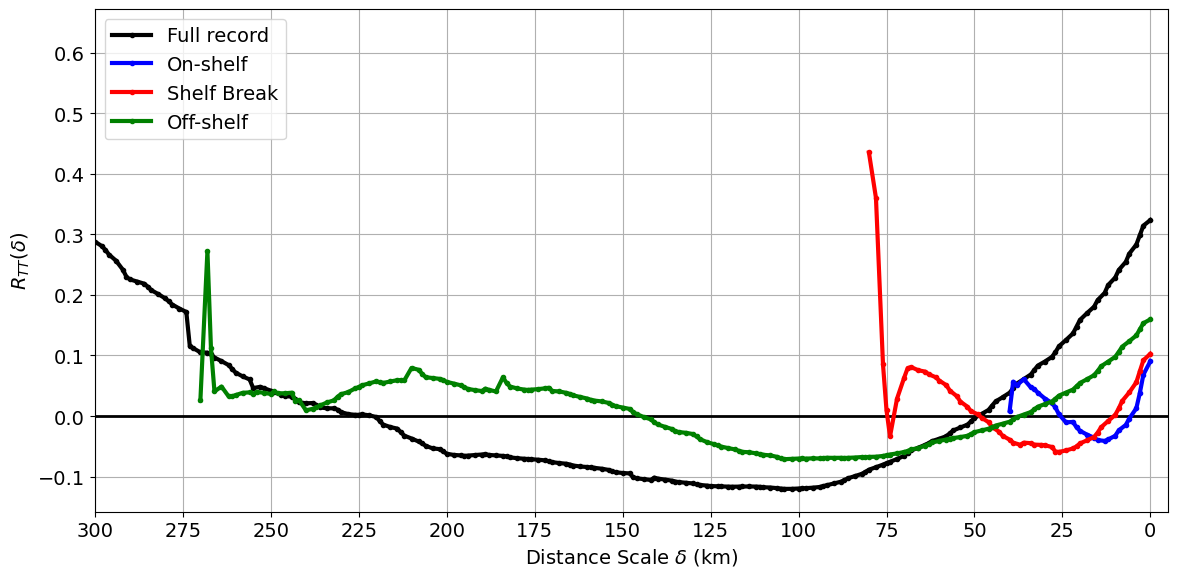

In [17]:
# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$R_{TT} (\delta)$'
elif option_var == 'sal':
    ylabel = r'$R_{SS} (\delta)$'
elif option_var == 'doxy':
    ylabel = r'$R_{OO} (\delta)$'
elif option_var == 'chla':
    ylabel = r'$R_{CC} (\delta)$'
elif option_var == 'density': 
    ylabel = r'$R_{\sigma\sigma} (\delta)$'

# Create figure 
fig = plt.figure(figsize=(12, 6))

# Plot the zero crossing line
plt.axhline(0, color='k', linestyle='-', linewidth=2)

# Plot the mean autocorrelation functions 
plt.plot(D_full_cov,meanAutoCov_full, 'k.-', linewidth=3, label="Full record")
plt.plot(D_on_cov,meanAutoCov_on, 'b.-', linewidth=3, label="On-shelf")
plt.plot(D_trans_cov,meanAutoCov_trans, 'r.-', linewidth=3, label="Shelf Break")
plt.plot(D_off_cov,meanAutoCov_off, 'g.-', linewidth=3, label="Off-shelf")

# Set axis attributes
plt.xlabel(r"Distance Scale $\delta$ (km)")
plt.ylabel(ylabel)
plt.xlim(-5,300)
#plt.ylim(-0.4,1.1)
plt.xticks(np.arange(0,300+25,25))
plt.grid()
plt.legend(loc="upper left")

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis() 

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/autocov_' + option_var + '_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_unbiased', bbox_inches = 'tight', dpi=300)

Plot the decorrelation time scale for each segment

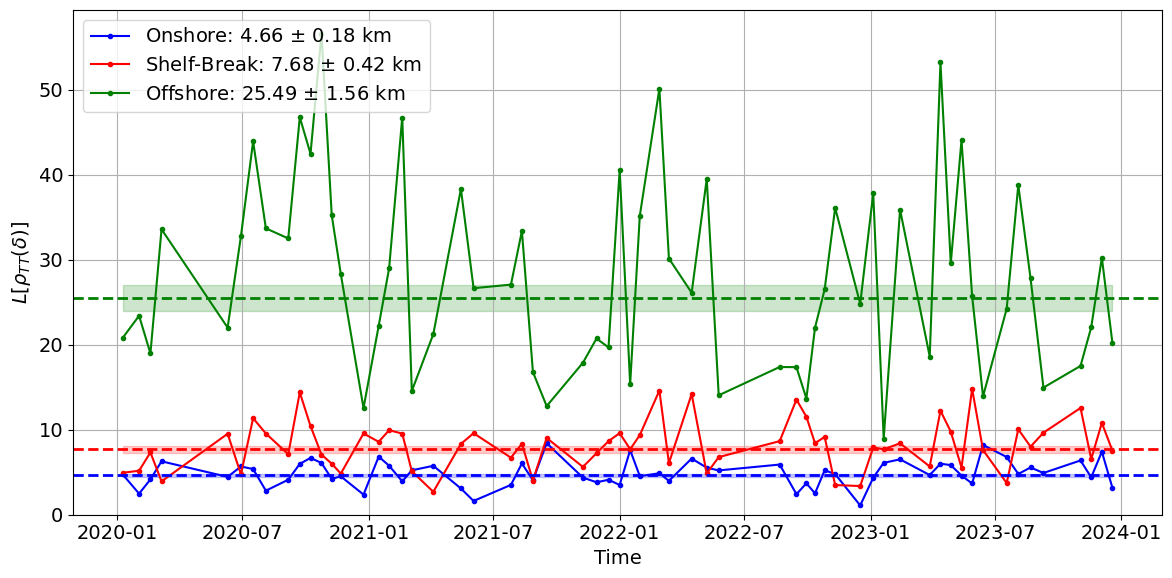

In [18]:
# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
elif option_var == 'doxy':
    ylabel = r'$\rho_{OO} (\delta)$'
elif option_var == 'chla':
    ylabel = r'$\rho_{CC} (\delta)$'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Create figure 
fig = plt.figure(figsize=(12, 6))

# Plot the decorrelation scale
plt.plot(meanTime,L_on_a,'b.-')
plt.plot(meanTime,L_trans_a,'r.-')
plt.plot(meanTime,L_off_a,'g.-')

# Plot onshelf, offshelf, and transition region decorrelation scales
plt.axhline(L_on, color='b', linestyle='--', linewidth=2)
plt.axhline(L_trans, color='r', linestyle='--', linewidth=2)
plt.axhline(L_off, color='g', linestyle='--', linewidth=2)

# Plot the standard error of the mean for the onshelf, offshelf, and transition region decorrelation scales
plt.fill_between(meanTime,L_on - L_on_stdm,L_on + L_on_stdm,color='b',alpha=0.2)
plt.fill_between(meanTime,L_trans - L_trans_stdm, L_trans + L_trans_stdm,color='r',alpha=0.2)
plt.fill_between(meanTime,L_off - L_off_stdm, L_off + L_off_stdm,color='g',alpha=0.2)

# Set axis attributes
plt.xlabel(r"Time")
plt.ylabel(r"$L[$" + ylabel + "$]$")
plt.ylim(ymin=0)
plt.grid()
plt.legend([r'Onshore: ' + str(np.round(L_on,2)) + r' $\pm$ ' + str(np.round(L_on_stdm,2)) + ' km', r'Shelf-Break: ' + str(np.round(L_trans,2)) + r' $\pm$ ' + str(np.round(L_trans_stdm,2)) + ' km' ,r'Offshore: ' + str(np.round(L_off,2)) + r' $\pm$ ' + str(np.round(L_off_stdm,2)) + ' km'], loc="upper left")

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
if option_interp == 0:
    fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/decorr_scale_' + option_var +'_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_' + estimator + '_bin_averaged', bbox_inches = 'tight', dpi=300)
else: 
    fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/decorr_scale_' + option_var +'_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_' + estimator + '_interpolated', bbox_inches = 'tight', dpi=300)

Compute the power spectrum from the mean autocorrelation function 

In [19]:
# Create the negative lagged mean autocovariance function
meanAutoCov_on_pos = meanAutoCov_on
meanAutoCov_on_neg = np.flip(meanAutoCov_on)[:-1]

meanAutoCov_trans_pos = meanAutoCov_trans
meanAutoCov_trans_neg = np.flip(meanAutoCov_trans)[:-1]

meanAutoCov_off_pos = meanAutoCov_off
meanAutoCov_off_neg = np.flip(meanAutoCov_off)[:-1]

meanAutoCov_full_pos = meanAutoCov_full
meanAutoCov_full_neg = np.flip(meanAutoCov_full)[:-1]

# Set spectral parameters
M_on = int(np.floor(len(meanAutoCov_on)/4))       # Half-width of data points (omitting the poorly sampled edges of the spectrum due to the uncertainty in the autocovariance function at large lags)
M_trans = int(np.floor(len(meanAutoCov_trans)/4))
M_off = int(np.floor(len(meanAutoCov_off)/4))
M_full = int(np.floor(len(meanAutoCov_full)/4))
window = 'hanning'
units = 'Hz'

# Compute the spectrum in each region
_, S_on, f_on, CI_on, var_freq_on = spectra_autocov(meanAutoCov_on_pos, meanAutoCov_on_neg, M_on, L, units)
_, S_trans, f_trans, CI_trans, var_freq_trans = spectra_autocov(meanAutoCov_trans_pos, meanAutoCov_trans_neg, M_trans, L, units)
_, S_off, f_off, CI_off, var_freq_off = spectra_autocov(meanAutoCov_off_pos, meanAutoCov_off_neg, M_off, L, units)
_, S_full, f_full, CI_full, var_freq_full = spectra_autocov(meanAutoCov_full_pos, meanAutoCov_full_neg, M_full, L, units)

Plot the power spectrum for each region 

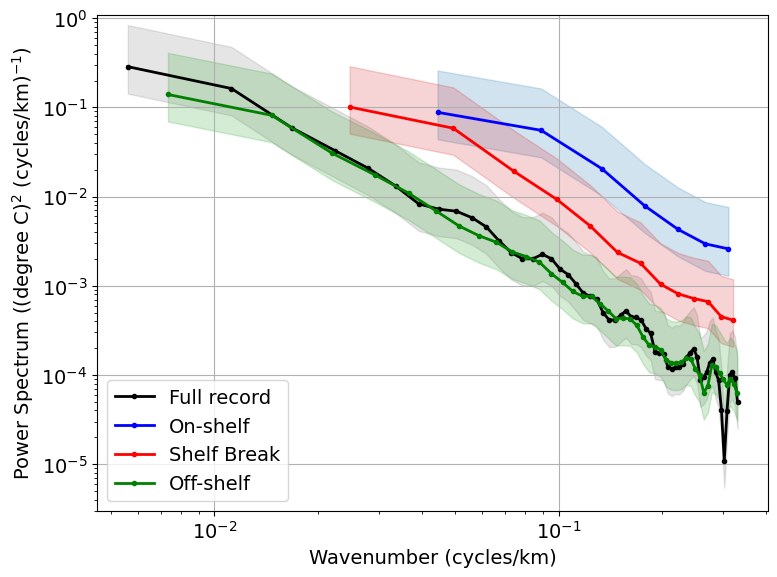

In [20]:
# Set the y label for the power spectrum
if option_var == 'temp':
    y_label = r'degree C'
elif option_var == 'sal':
    y_label = r'psu'
elif option_var == 'doxy':
    y_label = r'kg$^{-1}$'
elif option_var == 'chla':
    y_label = r'mg m$^{-3}$'
elif option_var == 'density': 
    y_label = r'kg m$^{-3}$'

# Create figure 
fig = plt.figure(figsize=(8, 6))

# Plot the mean autocorrelation functions 
plt.loglog(f_full[1:],S_full[1:], 'k.-', linewidth=2)
plt.loglog(f_on[1:],S_on[1:], 'b.-', linewidth=2)
plt.loglog(f_trans[1:],S_trans[1:], 'r.-', linewidth=2)
plt.loglog(f_off[1:],S_off[1:], 'g.-', linewidth=2)

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(f_full[1:],CI_full[1:,0],CI_full[1:,1],color="tab:gray",alpha=0.2)
plt.fill_between(f_on[1:],CI_on[1:,0],CI_on[1:,1],color="tab:blue",alpha=0.2)
plt.fill_between(f_trans[1:],CI_trans[1:,0],CI_trans[1:,1],color="tab:red",alpha=0.2)
plt.fill_between(f_off[1:],CI_off[1:,0],CI_off[1:,1],color="tab:green",alpha=0.2)

# Set axis attributes
plt.xlabel(r"Wavenumber (cycles/km)")
plt.ylabel(r'Power Spectrum ((' + y_label + ')$^2$ (cycles/km)$^{-1}$)')
plt.ylim(-0.4,1.1)
plt.grid()
plt.legend(["Full record","On-shelf", "Shelf Break", "Off-shelf"], loc="lower left")

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
if option_interp == 0:
    fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/power_spectrum_' + option_var + '_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_bin_average', bbox_inches = 'tight', dpi=300)
else: 
    fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/power_spectrum_' + option_var + '_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_interpolated', bbox_inches = 'tight', dpi=300)